In [1]:
# Import full version of csvs, based on config.py
import pandas as pd
from random_access.configs import simulation_configs

# Import all csvs, based on config.py
dataframes = {}
for config in simulation_configs:
    label = config['label'].replace(' ', '_').lower()
    csv_file = f"csv/obss_simulation_{label}.csv"
    dataframes[label] = pd.read_csv(csv_file)

# Hitmap for channel utilization

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import re

# 채널 utilization 계산 함수
def get_channel_utilization(label):
    df = dataframes[label]
    utilization = []
    for ch in ['0', '1']:
        backoff_condition = df[f'backoff_ch_{ch}'].apply(lambda x: ast.literal_eval(x).count(0) == 1)
        utilization.append(
            df[backoff_condition][f'channel_{ch}_occupied_until'].astype(bool).sum() / len(df)
        )
    return utilization

# 모든 label에 대해 utilization 수집
records = []
for label in dataframes.keys():
    util_ch0, util_ch1 = get_channel_utilization(label)
    
    match = re.match(r's(\d+)_(\d+)_f(short|long)_npca_(\d)', label)
    if match:
        ch0 = int(match.group(1))
        ch1 = int(match.group(2))
        frame = match.group(3)
        npca = int(match.group(4))  # ← npca 값을 정수로 추출

        records.append({
            "label": label,
            "ch0": ch0,
            "ch1": ch1,
            "frame": frame,
            "npca": npca,
            "util_ch0": util_ch0,
            "util_ch1": util_ch1
        })

df_util = pd.DataFrame(records)


In [8]:
dataframes.keys()  # 데이터프레임 키 확인

dict_keys(['s2_2_fshort_npca_1', 's2_2_fshort_npca_0', 's2_2_flong_npca_1', 's2_2_flong_npca_0', 's2_6_fshort_npca_1', 's2_6_fshort_npca_0', 's2_6_flong_npca_1', 's2_6_flong_npca_0', 's2_10_fshort_npca_1', 's2_10_fshort_npca_0', 's2_10_flong_npca_1', 's2_10_flong_npca_0', 's6_2_fshort_npca_1', 's6_2_fshort_npca_0', 's6_2_flong_npca_1', 's6_2_flong_npca_0', 's6_6_fshort_npca_1', 's6_6_fshort_npca_0', 's6_6_flong_npca_1', 's6_6_flong_npca_0', 's6_10_fshort_npca_1', 's6_10_fshort_npca_0', 's6_10_flong_npca_1', 's6_10_flong_npca_0', 's10_2_fshort_npca_1', 's10_2_fshort_npca_0', 's10_2_flong_npca_1', 's10_2_flong_npca_0', 's10_6_fshort_npca_1', 's10_6_fshort_npca_0', 's10_6_flong_npca_1', 's10_6_flong_npca_0', 's10_10_fshort_npca_1', 's10_10_fshort_npca_0', 's10_10_flong_npca_1', 's10_10_flong_npca_0'])

In [15]:
df_util[(df_util["frame"] == "short") & (df_util["npca"] == 1)]

,label,ch0,ch1,frame,npca,util_ch0,util_ch1
0,s2_2_fshort_npca_1,2,2,short,1,0.81520,0.68028
4,s2_6_fshort_npca_1,2,6,short,1,0.82401,0.65074
8,s2_10_fshort_npca_1,2,10,short,1,0.83304,0.63093
12,s6_2_fshort_npca_1,6,2,short,1,0.76201,0.67221
16,s6_6_fshort_npca_1,6,6,short,1,0.76743,0.65571
20,s6_10_fshort_npca_1,6,10,short,1,0.76799,0.61743
24,s10_2_fshort_npca_1,10,2,short,1,0.71671,0.68838
28,s10_6_fshort_npca_1,10,6,short,1,0.72423,0.65175
32,s10_10_fshort_npca_1,10,10,short,1,0.71973,0.61842


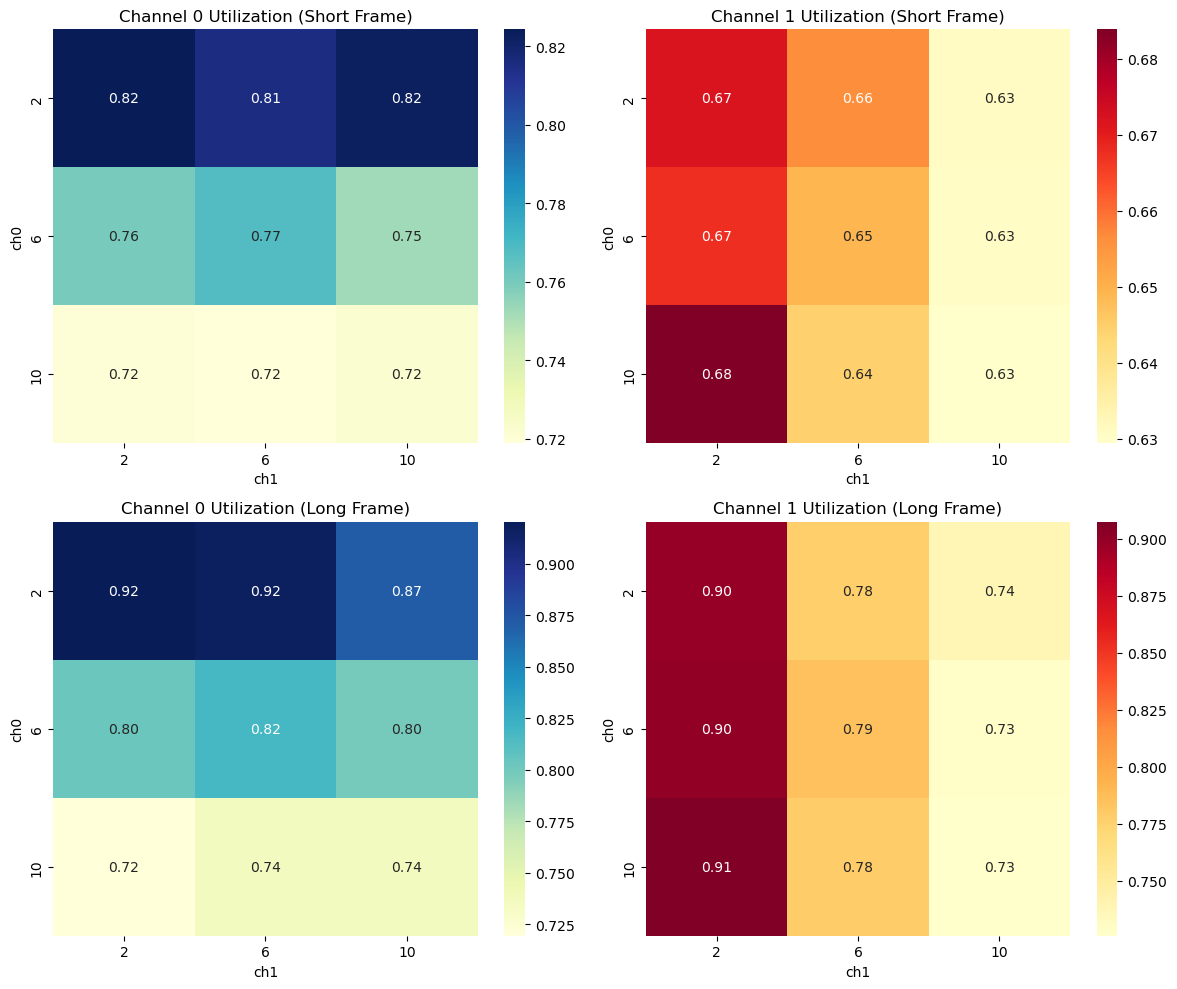

In [18]:
# NPCA OFF
df_short = df_util[(df_util["frame"] == "short") & (df_util["npca"] == 0)]
df_long = df_util[(df_util["frame"] == "long") & (df_util["npca"] == 0)]

pivot_ch0_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch1")
pivot_ch0_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch1")


# 히트맵 시각화
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pivot_ch0_short, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Channel 0 Utilization (Short Frame)")

plt.subplot(2, 2, 2)
sns.heatmap(pivot_ch1_short, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Channel 1 Utilization (Short Frame)")

plt.subplot(2, 2, 3)
sns.heatmap(pivot_ch0_long, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Channel 0 Utilization (Long Frame)")

plt.subplot(2, 2, 4)
sns.heatmap(pivot_ch1_long, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Channel 1 Utilization (Long Frame)")

plt.tight_layout()
plt.show()


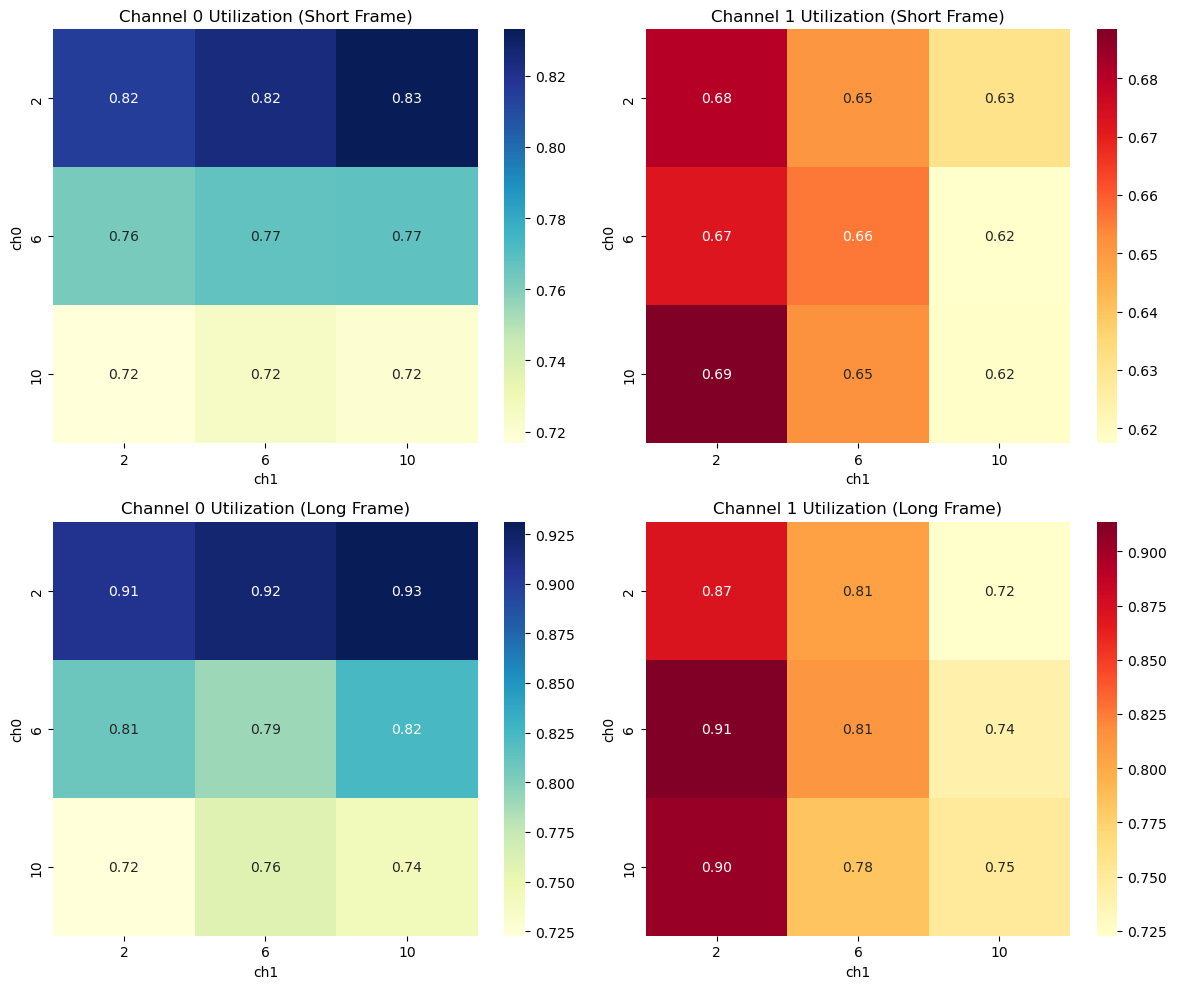

In [ ]:
# NPCA ON
df_short = df_util[(df_util["frame"] == "short") & (df_util["npca"] == 1)]
df_long = df_util[(df_util["frame"] == "long") & (df_util["npca"] == 1)]

pivot_ch0_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch1")
pivot_ch0_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch1")


# 히트맵 시각화
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pivot_ch0_short, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Channel 0 Utilization (Short Frame)")

plt.subplot(2, 2, 2)
sns.heatmap(pivot_ch1_short, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Channel 1 Utilization (Short Frame)")

plt.subplot(2, 2, 3)
sns.heatmap(pivot_ch0_long, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Channel 0 Utilization (Long Frame)")

plt.subplot(2, 2, 4)
sns.heatmap(pivot_ch1_long, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Channel 1 Utilization (Long Frame)")

plt.tight_layout()
plt.show()


# Tput per each STA

In [19]:
import ast
from collections import Counter

def get_successful_stas(label, channel=0):
    df = dataframes[label]
    col_backoff = f'backoff_ch_{channel}'
    col_state = f'states_ch_{channel}'

    success_counter = Counter()
    
    for i, row in df.iterrows():
        backoffs = ast.literal_eval(row[col_backoff])
        states = ast.literal_eval(row[col_state])
        
        # 0이 정확히 하나일 경우
        if backoffs.count(0) == 1:
            idx = backoffs.index(0)
            if states[idx] == 'primary_transmitting':
                success_counter[idx] += 1

    # Throughput fraction 계산
    simulation_time = len(df)
    throughput = pd.Series(success_counter).sort_index() / simulation_time
    return throughput

# 출력
for label in dataframes.keys():
    for ch in [0, 1]:
        sta_tp = get_successful_stas(label, channel=ch)
        print(f"Channel {ch} STA Throughput (Success/μs) for {label}:")
        print(sta_tp)
        print()


Channel 0 STA Throughput (Success/μs) for s2_2_fshort_npca_1:
0    0.40359
1    0.41161
dtype: float64

Channel 1 STA Throughput (Success/μs) for s2_2_fshort_npca_1:
0    0.33330
1    0.34698
dtype: float64

Channel 0 STA Throughput (Success/μs) for s2_2_fshort_npca_0:
0    0.40458
1    0.41976
dtype: float64

Channel 1 STA Throughput (Success/μs) for s2_2_fshort_npca_0:
0    0.33198
1    0.33990
dtype: float64

Channel 0 STA Throughput (Success/μs) for s2_2_flong_npca_1:
0    0.4349
1    0.4719
dtype: float64

Channel 1 STA Throughput (Success/μs) for s2_2_flong_npca_1:
0    0.44231
1    0.42900
dtype: float64

Channel 0 STA Throughput (Success/μs) for s2_2_flong_npca_0:
0    0.43522
1    0.48510
dtype: float64

Channel 1 STA Throughput (Success/μs) for s2_2_flong_npca_0:
0    0.44220
1    0.45641
dtype: float64

Channel 0 STA Throughput (Success/μs) for s2_6_fshort_npca_1:
0    0.42603
1    0.39798
dtype: float64

Channel 1 STA Throughput (Success/μs) for s2_6_fshort_npca_1:
0    0.0